In [1]:
'''
Multi-period inventory management
Hector Perez, Christian Hubbs, Owais Sarwar
3/18/2020
'''

import gym, itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
from scipy.optimize import line_search, minimize

In [2]:
class SupplyChain(gym.Env):
    '''
    The supply chain environment is structured as follows:
    
    It is a multiperiod multiechelon production-inventory system for a single non-perishable product that is sold only
    in discrete quantities. Each stage in the supply chain consists of an inventory holding area and a production area.
    The exception are the first stage (retailer: only inventory area) and the last stage (raw material transformation
    plant: only production area, with unlimited raw material availability). The inventory holding area holds the inventory
    necessary to produce the material at that stage. One unit of inventory produces one unit of product at each stage.
    There are lead times between the transfer of material from one stage to the next. The outgoing material from stage i 
    is the feed material for production at stage i-1. Stages are numbered in ascending order: Stages = {0, 1, ..., M} 
    (i.e. m = 0 is the retailer). Production at each stage is bounded by the stage's production capacity and the available
    inventory.
        
    At the each time period, the following sequence of events occurs:
    
    0) Stages 0 through M-1 place replinishment orders to their respective suppliers. Replenishment orders are filled
        according to available production capacity and available inventory at the respective suppliers.
    1) Stages 0 through M-1 receive incoming inventory replenishment shipments that have made it down the product pipeline
        after the stage's respective lead time.
    2) Customer demand occurs at stage 0 (retailer). It is sampled from a specified discrete probability distribution.
    3) Demand is filled according to available inventory at stage 0.
    4) Option: one of the following occurs,
        a) Unfulfilled sales and replenishment orders are backlogged at a penalty. 
            Note: Backlogged sales take priority in the following period.
        b) Unfulfilled sales and replenishment orders are lost with a goodwill loss penalty. 
    5) Surpluss inventory is held at each stage at a holding cost.
        
    '''
    def __init__(self, periods, I0, p, r, k, h, c, L, backlog, dist, dist_param, seed=0):
        '''
        periods = [positive integer] number of periods in simulation.
        I0 = [non-negative integer; dimension |Stages|-1] initial inventories for each stage.
        p = [positive float] unit price for final product.
        r = [non-negative float; dimension |Stages|] unit cost for replenishment orders at each stage.
        k = [non-negative float; dimension |Stages|] backlog cost or goodwill loss (per unit) for unfulfilled orders (demand or replenishment orders).
        h = [non-negative float; dimension |Stages|-1] unit holding cost for excess on-hand inventory at each stage.
            (Note: does not include pipeline inventory).
        c = [positive integer; dimension |Stages|-1] production capacities for each suppliers (stages 1 through |Stage|).
        L = [non-negative integer; dimension |Stages|-1] lead times in betwen stages.
        backlog = [boolean] are unfulfilled orders backlogged? True = backlogged, False = lost sales.
        dist = [integer] value between 1 and 4. Specifies distribution for customer demand.
            1: poisson distribution
            2: binomial distribution
            3: uniform random integer
            4: geometric distribution
        dist_param = [dictionary] named values for parameters fed to statistical distribution.
            poisson: {'mu': <mean value>}
            binom: {'n': <mean value>, 'p': <probability between 0 and 1 of getting the mean value>}
            raindint: {'low' = <lower bound>, 'high': <upper bound>}
            geom: {'p': <probability. Outcome is the number of trials to success>}
        seed = [integer] seed for random state.
        '''
        #set random generation seed
        self.seed(seed) 
        
        #input parameters
        self.init_inv = I0
        self.num_periods = periods
        self.unit_price = np.append(p,r[:-1]) #cost to stage 1 is price to stage 2
        self.unit_cost = np.array(r)
        self.demand_cost = np.array(k)
        self.holding_cost = np.append(h,0) #holding cost at last stage is 0
        self.supply_capacity = np.array(c)
        self.lead_time = np.array(L)
        self.backlog = backlog
        
        #intermediate calculation
        m = len(I0) + 1 #number of stages
        self.num_stages = m
        
        #parameters
        #dictionary with options for demand distributions
        distributions = {1:poisson,
                         2:binom,
                         3:randint,
                         4:geom}
        #distribution parameters
        self.dist_param = dist_param
        
        #check inputs
        assert m >= 2, "The minimum number of stages is 2. Please try again"
        assert len(r) == m, "The length of r is not equal to the number of stages."
        assert len(k) == m, "The length of k is not equal to the number of stages."
        assert len(h) == m-1, "The length of h is not equal to the number of stages - 1."
        assert len(c) == m-1, "The length of c is not equal to the number of stages - 1."
        assert len(L) == m-1, "The length of L is not equal to the number of stages - 1."
        assert dist in [1,2,3,4], "dist must be one of 1, 2, 3, 4."
        assert distributions[dist].cdf(0,**dist_param), "Wrong parameters given for distribution."
        
        #select distribution
        self.demand_dist = distributions[dist]  
        
        #intialize
        self.reset()
        
        #define spaces
        #action space (reorder quantities for each stage; list)
        action_i = gym.spaces.Discrete(2**31) #very large number (should be unbounded in reality)
        action = [action_i for i in range(m-1)] #an action is defined for every stage (except last one)
        action_tuple = tuple(action) #convert list to tuple
        self.action_space = gym.spaces.Tuple(action_tuple) #(i.e. if 2 stages, then aciton space is (0 to 4294967295, 0 to 4294967295))
        #observation space (Inventory position at each echelon, which is any integer value)
        self.observation_space = gym.spaces.Box(low=-np.Inf, high=np.Inf, shape = (m-1,))#, dtype=np.int32)
        
    def seed(self,seed=None):
        '''
        Set random number generation seed
        '''
        #seed random state
        if seed != None:
            np.random.seed(seed=int(seed))
        
    def reset(self):
        '''
        Create and initialize all variables and containers.
        Nomenclature:
            I = On hand inventory at the start of each period at each stage (except last one).
            T = Pipeline inventory at the start of each period at each stage (except last one).
            R = Replenishment order placed at each period at each stage (except last one).
            D = Customer demand at each period (at the retailer)
            S = Sales performed at each period at each stage.
            B = Backlog at each period at each stage.
            LS = Lost sales at each period at each stage.
            P = Total profit at each stage.
        '''
        periods = self.num_periods
        m = self.num_stages
        I0 = self.init_inv
        
        #simulation result lists
        self.I=np.zeros([periods + 1, m - 1]) #inventory at the beginning of each period (last stage not included since iventory is infinite)
        self.T=np.zeros([periods + 1, m - 1]) #pipeline inventory at the beginning of each period (no pipeline inventory for last stage)
        self.R=np.zeros([periods, m - 1]) #replenishment order (last stage places no replenishment orders)
        self.D=np.zeros(periods) #demand at retailer
        self.S=np.zeros([periods, m]) #units sold
        self.B=np.zeros([periods, m]) #backlog (includes top most production site in supply chain)
        self.LS=np.zeros([periods, m]) #lost sales
        self.P=np.zeros(periods) #profit
        
        #initializetion
        self.period = 0 #initialize time
        self.I[0,:]=np.array(I0) #initial inventory
        self.T[0,:]=np.zeros(m-1) #initial pipeline inventory
        
        #set state
        self._update_state()
        
        return self.state
    
    def _update_state(self):
        '''
        Get current state of the system: Inventory position at each echelon
        Inventory at hand + Pipeline inventory - backlog up to the current stage 
        (excludes last stage since no inventory there, nor replenishment orders placed there).
        '''
        n = self.period
        m = self.num_stages
        if n>=1:
            IP = np.cumsum(self.I[n,:] + self.T[n,:] - self.B[n-1,:-1]) 
        else:
            IP = np.cumsum(self.I[n,:] + self.T[n,:])
        self.state = IP
    
    def step(self,action):
        '''
        Take a step in time in the multiperiod inventory management problem.
        action = [integer; dimension |Stages|-1] number of units to request from suppliers (last stage makes no requests)
        '''
        #get inventory at hand and pipeline inventory at beginning of the period
        n = self.period
        L = self.lead_time
        I = self.I[n,:].copy() #inventory at start of period n
        T = self.T[n,:].copy() #pipeline inventory at start of period n
        m = self.num_stages #number of stages
        
        #get production capacities
        c = self.supply_capacity #capacity
        
        #available inventory at the m+1 stage (note: last stage has unlimited supply)
        Im1 = np.append(I[1:], np.Inf) 
        
        #place replenishment order
        R = action.astype(int)
        R[R<0] = 0 #force non-negativity
        if n>=1: #add backlogged replenishment orders to current request
            R = R + self.B[n-1,1:]
        Rcopy = R #copy oritignal replenishment quantity
        R[R>=c] = c[R>=c] #enforce capacity constraint
        R[R>=Im1] = Im1[R>=Im1] #enforce available inventory constraint
        self.R[n,:] = R #store R[n]
        
        #receive inventory replenishment placed L periods ago
        RnL = np.zeros(m-1) #initialize
        for i in range(m-1):
            if n - L[i] >= 0:
                RnL[i] = self.R[n-L[i],i].copy() #replenishment placed at the end of period n-L-1
                I[i] = I[i] + RnL[i]
            
        #demand is realized
        try:
            D0 = self.demand_dist.rvs(**self.dist_param)
        except:
            print("Distribution parameters incorrect. Try again.")
            raise   
        D = D0 #demand
        self.D[n] = D0 #store D[n]
        
        #add previous backlog to demand
        if n >= 1:
            D = D0 + self.B[n-1,0].copy() #add backlogs to demand
        
        #units sold
        S0 = min(I[0],D) #at retailer
        S = np.append(S0,R) #at each stage
        self.S[n,:] = S #store S[n]
        
        #update inventory at hand and pipeline inventory
        I = I - S[:-1] #updated inventory at all stages (exclude last stage)
        T = T - RnL + R #updated pipeline inventory at all stages (exclude last one)
        self.I[n+1,:] = I #store inventory available at start of period n + 1 (exclude last stage)
        self.T[n+1,:] = T #store pipeline inventory at start of period n + 1
        
        #unfulfilled orders
        U = np.append(D,Rcopy) - S #unfulfilled demand and replenishment orders
        
        #backlog and lost sales
        if self.backlog:
            B = U
            LS = np.zeros(m) 
        else:
            LS = U #lost sales
            B = np.zeros(m)
        self.B[n,:] = B #store B[n]
        self.LS[n,:] = LS #store LS[n]

        #calculate profit
        p = self.unit_price 
        r = self.unit_cost 
        k = self.demand_cost
        h = self.holding_cost
        II = np.append(I,0) #augment inventory so that last has no onsite inventory
        RR = np.append(R,S[-1]) #augment replenishment orders to include production cost at last stage
        P = np.sum(p*S - (r*RR + k*U + h*II)) #profit in period n
        self.P[n] = P #store P
        
        #update period
        self.period += 1  
        
        #update stae
        self._update_state()
        
        #return values
        reward = P #profit at current period
        if self.period >= self.num_periods:
            done = True
        else:
            done = False
        return self.state, reward, done, {}
    
    def sample_action(self):
        '''
        Generate an action by sampling from the action_space
        '''
        return self.action_space.sample()
        
    def base_stock_action(self,z):
        '''
        Sample action (number of units to request) based on a base-stock policy (order up to z policy)
        z = [integer list; dimension |Stages| - 1] base stock level (no inventory at the last stage)
        '''
        n = self.period
        c = self.supply_capacity
        m = self.num_stages
        IP = self.state #extract inventory position (current state)
        
        assert len(z) == m-1, "Wrong dimension on base stock level vector. Should be #Stages - 1."
        
        #calculate total inventory position at the beginning of period n
        R = z - IP #replenishmet order to reach zopt

        #check if R can actually be fulfilled (capacity and inventory constraints)
        Im1 = np.append(self.I[n,1:], np.Inf) #available inventory at the m+1 stage
                                            #NOTE: last stage has unlimited raw materials
        Rpos = np.column_stack((np.zeros(len(R)),R)) #augmented materix to get replenishment only if positive
        A = np.column_stack((c, np.max(Rpos,axis=1), Im1)) #augmented matrix with c, R, and I_m+1 as columns
        
        R = np.min(A, axis = 1) #replenishmet order to reach zopt (capacity constrained)
        
        return R

In [3]:
def critical_ratio_base_stock(env):
    '''
    Use the critical factile formula to determine the R that will maximize expected profit
        z = invF(CR) = invF((p - r + k)/(p - r + k + h)).
    Only valid for zero lead time.
    env = [environment] simulation environment.
    '''
    p = env.unit_price 
    r = env.unit_cost 
    k = env.demand_cost
    h = env.holding_cost

    underage = p - r + k #benefit from selling an aditional unit
    overage = h #loss for not selling an additional unit in stock

    CR = underage / (underage + overage) #critical ratio
    zopt = env.demand_dist.ppf(q = CR,**env.dist_param) #optimal order up to level

    return zopt

def run_base_stock_sim(env,z):
    '''
    Run simulation using base-stock policy.
    env = [environment] simulation environment
    z = [integer list; dimension |Stages| - 1] base-stock levels for each stage
    '''
    m = env.num_stages
    assert len(z) == m-1, "Wrong dimension on base stock level vector. Should be #Stages - 1."
    
    for t in range(env.num_periods):
        #take a step in the simulation using critical ratio base stock
        env.step(action=env.base_stock_action(z=z)) 

def SP(x,*env_args):
    '''
    Compute negative of the average profit for a sample path (since we will be using minimization algo).
    x = [integer list; dimension |Stages| - 1] total inventory levels at each node.
    env_args = [list] arguments for simulation environment on which to perform SPA
    '''
    sim = SupplyChain(*env_args) #build simulation environment
    x = np.array(x) #inventory level at each node
    z = np.cumsum(x) #base stock levels
    sim.I[0,:] = x #set initial inventories
    run_base_stock_sim(sim,z) #run simulation
    return -np.mean(sim.P)
        
def SPA_base_stock_update(env_args, use_CR = False, local_search = False):
    '''
    Optimize base stock level on a simulated sample path. 
    
    env_args = [list] arguments for simulation environment on which to perform SPA.
    use_CR = [Boolean] use critical ratio optimal base-stock levels for the initial value.
    local_search = [Boolean] search neighborhood around NLP relaxation to get integer solution (by enumeration).
    '''      
    
    m = len(env_args[1]) #number of stages - 1 (inventory not counted at last stage)
    
    #build simulation environment (just to get the critical base stock level)
    if use_CR:
        sim = SupplyChain(*env_args) 
        z = critical_ratio_base_stock(sim) #get critical ratio base stock
    else:
        z = np.arange(1,m+1,1) #initial value for search (1 through m)
    x = np.diff(z, prepend = [0]) #calculate inventory levels at each stage from echelon levels
    env_args[1] = x #set initial inventories

    #run optimization
    res = minimize(fun = SP, x0 = x, args = tuple(env_args), method = 'Powell')#, bounds = [(0,None) for i in range(m)])
    print(res)
    xopt = res.x[()]
    fopt = -res.fun
    
    #local search to get integer solution
    if local_search:
        xopt_f = np.floor(xopt)
        xopt_c = np.ceil(xopt)
        X = np.column_stack((xopt_f,xopt_c))
        xlist = list(itertools.product(*X)) #2^|x| combinations around NLP relaxation optimum
        fopt = -np.Inf #initialize incumbent
        for x in xlist:
            f = -SP(x,*env_args)
            if f>fopt: #update incumbent
                fopt = f
                xopt = x
    
    #calculate base stock level
    zopt = np.cumsum(xopt)
    
    zopt=np.round(zopt)
    xopt=np.round(xopt)
    return zopt, xopt, fopt

   direc: array([[0.        , 1.        ],
       [0.14535085, 0.        ]])
     fun: -2.9134999893698477
 message: 'Optimization terminated successfully.'
    nfev: 173
     nit: 2
  status: 0
 success: True
       x: array([10.99999468,  1.        ])
SPA zopt: [11. 12.]
SPA optimal profit: 2.9134999893698477

Retailer 0: $596.80


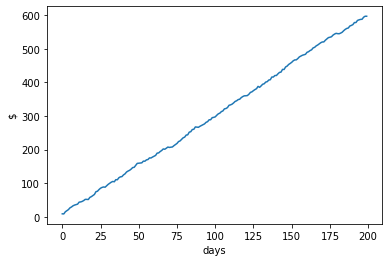

In [4]:
#test (multi-echelon)

#inputs
periods = 200 #simulation periods
p = 1
r = [0.2,0.2,0.2]
k = [0.3,0.3,0]
h = [0.1,0.1]
L = [0,0]
c = [100,100]
I0 = [0,0]
backlog = True
dist = 1 #distribution selection
dist_param = {'mu':5} #distribution parameters
param=[periods,I0,p,r,k,h,c,L,backlog,dist,dist_param,10]

#run SPA
zopt,xopt,fopt = SPA_base_stock_update(param)

print("SPA zopt: {}".format(zopt))
print("SPA optimal profit: {}".format(fopt))

#set initial inventory
I0 = xopt

#run base-stock policy with SPA result
retailer0=SupplyChain(periods, I0, p, r, k, h, c, L, backlog, dist, dist_param, 0)
for t in range(retailer0.num_periods):
    retailer0.step(action=retailer0.base_stock_action(z=zopt))
print()

#plot profit
print("Retailer 0: $%.2f" %sum(retailer0.P))
plt.plot([sum(retailer0.P[:t+1]) for t in range(retailer0.num_periods)])
plt.xlabel('days')
plt.ylabel('$')
plt.show()

   direc: array([[-0.4256368]])
     fun: -3.8793441603567103
 message: 'Optimization terminated successfully.'
    nfev: 57
     nit: 2
  status: 0
 success: True
       x: array(6.99747754)
SPA zopt: [7.]
SPA optimal profit: 3.84


Retailer 0: $23.70
Retailer 1: $11.30
Retailer 2: $23.70


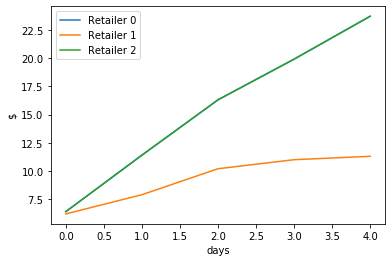

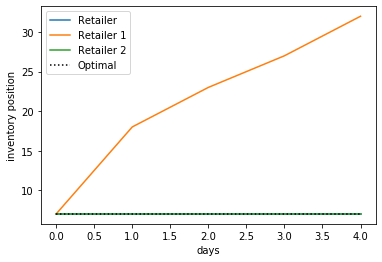

In [5]:
#test (single echelon)

#inputs
periods = 5 #simulation periods
p = 1
r = [0.2,0.2]
k = [0.3,0]
h = [0.1]
L = [0]
c = [10]
I0 = [0]
backlog = True
dist = 1 #distribution selection
dist_param = {'mu':5} #distribution parameters
param=[periods,I0,p,r,k,h,c,L,backlog,dist,dist_param,10]

#run SPA
zopt,xopt,fopt = SPA_base_stock_update(param,local_search=True)

print("SPA zopt: {}".format(zopt))
print("SPA optimal profit: {}".format(fopt))

#set initial inventory
I0=xopt
m = len(np.array([I0])) #number of stages - 1

#run base-stock policy with SPA result
retailer0=SupplyChain(periods, I0, p, r, k, h, c, L, backlog, dist, dist_param, 0)
for t in range(retailer0.num_periods):
    retailer0.step(action=retailer0.base_stock_action(z=zopt))
print()

#run random action
retailer1=SupplyChain(periods, I0, p, r, k, h, c, L, backlog, dist, dist_param, 0)
for t in range(retailer1.num_periods):
    retailer1.step(action=np.array([retailer1.sample_action()[0]]))
print()

#run policy: replenishment order = demand
retailer2=SupplyChain(periods, I0, p, r, k, h, c, L, backlog, dist, dist_param, 0)
for t in range(retailer2.num_periods):
    if t == 0:
        action = np.zeros(m)
    else:
        makeup = max(-(t-m),0)
        if makeup == 0:
            action = retailer2.D[t-m:t]
        else:
            action = np.append(retailer2.D[0]*np.ones(makeup), retailer2.D[max(t-m,0):t])
    retailer2.step(action=action)

#plot profits
print("Retailer 0: $%.2f" %sum(retailer0.P))
print("Retailer 1: $%.2f" %sum(retailer1.P))
print("Retailer 2: $%.2f" %sum(retailer2.P))
plt.plot([sum(retailer0.P[:t+1]) for t in range(retailer0.num_periods)])
plt.plot([sum(retailer1.P[:t+1]) for t in range(retailer1.num_periods)])
plt.plot([sum(retailer2.P[:t+1]) for t in range(retailer2.num_periods)])
plt.legend(['Retailer 0','Retailer 1','Retailer 2'])
plt.xlabel('days')
plt.ylabel('$')
plt.show()

#plot inventory positions
plt.plot(np.append(I0,[retailer0.I[i,0]+retailer0.T[i,0]-retailer0.B[i-1,0]+retailer0.R[i,0] for i in range(1,periods)]))
plt.plot(np.append(I0,[retailer1.I[i,0]+retailer1.T[i,0]-retailer1.B[i-1,0]+retailer1.R[i,0] for i in range(1,periods)]))
plt.plot(np.append(I0,[retailer2.I[i,0]+retailer2.T[i,0]-retailer2.B[i-1,0]+retailer2.R[i,0] for i in range(1,periods)]))
plt.plot(np.ones(periods)*zopt,'k:')
plt.legend(['Retailer','Retailer 1','Retailer 2','Optimal'])
plt.xlabel('days')
plt.ylabel('inventory position')
plt.show()

In [27]:
class testClass():
    
    def __init__(self, *args, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        if hasattr(self, 'env_config'):
            for key, value in self.env_config.items():
                setattr(self, key, value)

In [28]:
env_config = {'a': 10, 'b': 15}
x = testClass(p=123, j=190, env_config=env_config)

In [29]:
x.p

123

In [30]:
x.a

10

In [31]:
x.b

15

In [38]:
2**31*64 / 1000**3

137.438953472

In [36]:
268*64 / 1000

17.152